# Learning from Big Data: Module 1 - Final Assignment

#### Student Name: KUNAL RUPCHANDANI 571425KR

# Introduction

This file provides a template for **Assignment 1** from the Learning from Big Data course. This Jupyter Notebook file was prepared to save you time so that you can focus on the theory and technical parts of the methods seen in class. This was prepared with a specific application in mind: *movie reviews*. For the supervised learning tasks, we will focus on three topics: acting, storyline, and visual/sound effects.

You have by now received the dataset of reviews, the three dictionaries with the training set of words for each topic, a list of stopwords, and a validation dataset containing sentences classified by a panel of human judges. This Jupyter Notebook file has a lot of (Python) code written to handle things such as leading these data files and general settings of the environment we use to perform the analysis. The supervised learning code in this file was covered in **Session 02**.

This Jupyter Notebook file will load all the above-mentioned files and make them available for you to use them for solving the NLP problems listed here. The questions **you are to answer** are marked as "`QUESTION`". The parts **you are expected to code yourself** are marked as "`# ADD YOUR CODE HERE`". There, you are expected to write your own code based on the in-class discussions and the decisions you will make as you study the theory, material, and models.

#### This assignment has the following structure:
1. **General Guidelines**
2. **Research Question**
3. **Load the Packages**
4. **Load the Reviews**
5. **Data Aggregation and Formatting**
6. **Supervised Learning: The Naive Bayes Classifier (NBC)**
7. **Supervised Learning: Inspect the NBC Performance**
8. **Unsupervised Learning: Predicting the Box Office using LDA**
9. **Unsupervised Learning: Predicting the Box Office using Word2Vec**
10. **Analysis - Answering the Research Question**
11. **OPTIONAL - Run and interpret the VADER lexicon for sentiment**
12. **APPENDIX**

# 1. General Guidelines

**Page limit**. This template has 8 pages, and you are allowed to add 8 to 10 pages (not including the appendix). Even though there is a page limit, you have the possibility of using appendices, which do not have a limitation in the number of pages. Use your pages wisely. For example, having a table with 2 rows and 3 columns that uses 50% (or even 25%) of a page is not really wise.

# 2. Research Question

`QUESTION I:` Present here the main research question you are going to answer with your text analysis.
You are free to choose the problem and change it until the last minute before handing in your report. However, your question should not be so simple that it does not require text analysis. For example, if your question can be answered by reading two reviews, you do not need text analysis; all you need is 10 seconds to read two reviews. Your question should not be so difficult that you cannot answer in your report. Your question needs to be answered in these pages.




`SOLUTION I:` 
Research Question: To what extent are Airbnb ratings affected when sentiment about the host and sentiment towards cleanliness, location and facilities of the Airbnb are mentioned in an Airbnb review?

# 3. Load the Packages

Before starting the problem set, make sure that you have all the required packages installed properly. Simply run the code cell below (Shift-Enter). **Note**: you are free to add other packages.

In [430]:
# Loading the required packages
import re
import string
import numpy as np
import pandas as pd
import nltk
import ssl
from collections import Counter, namedtuple
from sklearn.feature_extraction import text
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numbers
import statsmodels.api as sm
import math

# Try Except block to ensure nltk is imported without any errors
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

# 4. Load the Airbnb Reviews

The raw data set contains the following columns:
+ **Title**: The title of the Airbnb property
+ **Image**: Link to the propery main image
+ **Rating**: Average rating of the Airbnb by users
+ **Total Reviews**: Total number of reviews, the property received from the users
+ **Location**: The country where the Airbnb is situated
+ **Price**: The price of the Airbnb per night
+ **Reviews**: List of Reviews per Airbnb
  
The data that is relevant to answering the RQ:
+ **Reviews**: Reviews split into sentences to be able to determine the category
+ **Total Reviews**: Total number of reviews corresponding to the proper
+ **Rating**: Average rating of the Airbnb by users (Float)

Variables that are created to assist in answering the research question
+ **Host_mentioned**: Binary variable that indicates if the review mentions the host (by name or as the 'host')
+ **P(positive|cleanliness)**: The probability of the review being positive across reviews talking about cleanliness
+ **P(positive|location)**: The probability of the review being positive across reviews talking about location
+ **P(positive|facilities)**: The probability of the review being positive across reviews talking about facilities

### Loading the reviews:

In [307]:
# Loading the data
reviews_raw = pd.read_csv('../data/reviews/airbnb_reviews.csv', encoding='ISO-8859-1')

# Removing the columns that are not needed
reviews_raw = reviews_raw[['Rating','Total Reviews', 'Reviews']]

# Removing all rows that are empty
reviews_cleaned = reviews_raw.dropna(subset = ['Rating','Total Reviews', 'Reviews'], how = 'any')

#Creating a dataframe where each row corresponds to one sentence (considered as a review from this point onwards)
sentence_level = pd.DataFrame(columns = ['Rating','Total Reviews', 'Reviews'])

i = 0

for index, row in tqdm(reviews_cleaned.iterrows()):
    rating = reviews_cleaned.loc[index, 'Rating']
    total_reviews = reviews_cleaned.loc[index, 'Total Reviews']
    
    #This was done to split the reviews into a sentence level for 
    reviews = row['Reviews']
    delimiter_pattern = r'[.!]'
    reviews = re.split(delimiter_pattern, reviews)

    for sentence in reviews:
        new_row = [rating, total_reviews, sentence]
        sentence_level.loc[i] = new_row
        i += 1

3324it [00:38, 85.68it/s] 


# 5. Data Aggregation and Formatting

In [308]:
# Text that do not contain any alphabetical characters are removed
mask = ~sentence_level['Reviews'].str.contains('[a-zA-Z]')
sentence_level = sentence_level[~mask]

# We remove all the stopwords manually through this function
stop_words = stopwords.words('english')
def remove_stopwords(sentence):
    words = sentence.split()  # Tokenize the sentence into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return " ".join(filtered_words)  # Return a list of words without stopwords

# Function that removes puncutation, numbers and any characters except alphabetical characters
def preprocessing(text):

    #Removing all characters such as '-' and replacing it whitespaces and only containing alphabets
    text = re.sub('[^a-zA-Z ]', '', text)

    #removing punctuation
    for word in text:
        if(word in string.punctuation):
            text = text.replace(word, "")

    # Removing more than one whitespaces
    text = re.sub(r'\s+', ' ', text)

    return text

#creating a new list of processed sentences based on the function above, use of lists to apply the preprocessing() function above
sentences_list = sentence_level['Reviews'].tolist()
preprocessed_sentences = []
for text in tqdm(sentences_list):
   preprocessed_sentences.append(preprocessing(text))
sentence_level['Reviews'] = preprocessed_sentences


#Creating the host_mentioned variable to be used as one of our independant variables
# Checking if the name of the host is mentioned
sentence_level['host_mentioned'] = None
for index,row in tqdm(sentence_level.iterrows()):
    nltk_results = ne_chunk(pos_tag(word_tokenize(row['Reviews'])))
    for nltk_result in nltk_results:
        if type(nltk_result) == Tree and nltk_result.label() == 'PERSON':
            sentence_level.at[index, 'host_mentioned'] = 1
            break
            
# Checking if the review contains the word host      
for index, row in tqdm(sentence_level.iterrows()):
    sentence = row['Reviews']
    words = sentence.split()
    for word in words:
        if word == 'host' or word == 'Host' or word == 'hosts' or word == 'Hosts':
            sentence_level.at[index, 'host_mentioned'] = 1
            break
            
# Setting rows where the host is not mentioned to zero          
sentence_level['host_mentioned'] = sentence_level['host_mentioned'].apply(lambda x: 0 if pd.isna(x) or x == '' else x)

#Finally removing the stopwords and lowercasing all the words for further 
processed_sentences = []
for text in tqdm(preprocessed_sentences):
    processed_sentences.append(remove_stopwords(text).lower())

#Setting aside 5% of the raw data for judges to build lexicon and saving it to a csv file to be distributed to judges.
total_category_lexicon = []
for i in range(math.floor(0.05*len(processed_sentences))):
    total_category_lexicon.append(processed_sentences[i])
df_lexicon = pd.DataFrame(total_category_lexicon, columns = ['Sentences'])
df_lexicon.to_csv("df_lexicon.csv", index = False)

# Setting another 5% of the raw data for the ground truth, when we want to evaluate our ground truth
ground_truth_judges = []
for j in range(math.floor(0.05*len(processed_sentences)), math.floor(0.10*len(processed_sentences))):
    ground_truth_judges.append(processed_sentences[j])
df_ground_truth_judges = pd.DataFrame(ground_truth_judges, columns = ['Sentences'])
df_ground_truth_judges.to_csv("ground_truth_judges.csv", index = False)

# Rest of the 90% of the data will be used in production (input of the NBC). The other 10% will not be used for any of the classification production.
available_sentences = []
for k in range(math.floor(0.10*len(processed_sentences)), len(processed_sentences)):
    available_sentences.append(processed_sentences[k])

100%|█████████████████████████████████| 59883/59883 [00:00<00:00, 254170.02it/s]
59883it [01:08, 878.83it/s] 
59883it [00:00, 70850.02it/s]
100%|█████████████████████████████████| 59883/59883 [00:00<00:00, 107274.70it/s]


In [309]:
# creating our dataframe to be used for our NBC classification
df_sentences = pd.DataFrame(available_sentences, columns = ['sentences'])
df_sentences.to_csv("test_df_sentences.csv", index = False)

In [310]:
#Creating the dataframe that will be used for our analysis (regression)
df_last_90_percent = sentence_level.iloc[math.floor(0.10*len(processed_sentences)):len(processed_sentences)]
final_df = pd.concat([df_last_90_percent])
final_df.to_csv("final_df.csv", index = False)

`QUESTION II:` Decide on how to aggregate or structure your data. The data you received is at the review level (i.e., each row/observation is a review). However, the variablese in the data are very rich and allow you to use your creativity when designing your *research question*. For example, there are timestamps, which allow you to aggregate the data at the daily level (or even hourly level). There is information on reviewers, which allow you to inspect patterns of rating by reviewers. There is information on the studio's, and more. Please explicitly indicate how you structured your dataset, and what is your motivation to do so. Even if you are using the data at the review level, indicate how and why that is needed for your research question. 

`SOLUTION II:` The raw Airbnb dataset, for each row has all the reviews for a particular Airbnb. These reviews will be split in such a way that one row corresponds to one sentence. This is to ensure that classification across the three categories is possible. Secondly, we also go through preprocessing the text before being able to apply to NBC classification, unsupervised learning and final analysis. This includes removing all other characters except the alphaebet (to ensure clean textual analysis), removing stopwords, punctuation and any uppercase alphabetical characters. Finally, the reviews were used to create our host_mentioned binary variable required to answer our research question. 

# 6. Supervised Learning: the Naive Bayes Classifier (NBC)

## 6.0 Load Support Functions and Global Parameters

The two functions, `compute_posterior_sentiment` and `compute_posterior_content`, are called once per review. These functions use the Bayes rule we saw in **Session 02** to compute the posterior probabilities that the review is about each topic (in the 2nd function) and the posterior probability that the sentiment in the review is positive and/or negative (in the 1st function). The functions are loading by executing the code cell below.

In [313]:
# Function for computing posterior sentiment
def compute_posterior_sentiment(prior, corpus_in, dict_words, p_w_given_c, TOT_DIMENSIONS):
    prior = np.array(prior)
    vec = CountVectorizer(vocabulary=dict_words, lowercase=False)
    word_matrix = vec.fit_transform([corpus_in]).toarray()
    # Check if there are any relevant words in the review, if there are, treat them. 
    # If not, use the prior.
    if word_matrix.sum() == 0:
        posterior = prior
        words_ = ['']
    else:
        # Positions in word matrix that have words from this review
        word_matrix_indices = np.where(word_matrix > 0)[1]

        # Initializing posterior vector
        posterior = np.zeros(TOT_DIMENSIONS)
        vec_likelihood = np.zeros(TOT_DIMENSIONS)

        # Loop around words found in review
        for word_matrix_index in word_matrix_indices:
            word = vec.get_feature_names_out()[word_matrix_index]

            # Check if the word exists in p_w_given_c.words
            p_w_given_c_indices = np.where(p_w_given_c.words == word)[0]
            if p_w_given_c_indices.size > 0:
                p_w_given_c_index = p_w_given_c_indices[0]
                vec_likelihood = np.array([p_w_given_c.pos_likelihood[p_w_given_c_index], 
                                           p_w_given_c.neg_likelihood[p_w_given_c_index]])

                # Looping around occurrences | word
                for i in range(word_matrix[0, word_matrix_index]):
                    numerat = prior * vec_likelihood
                    denomin = prior.dot(vec_likelihood)
                    posterior = numerat / denomin

                    if np.sum(posterior) > 1.01:
                        raise Exception('ERROR')

                    prior = np.array(posterior)

        words_ = vec.get_feature_names_out()[word_matrix_indices]

    return {'posterior_': posterior, 'words_': words_}
# Function for computing posterior content
def compute_posterior_content(prior, corpus_in, dict_words, p_w_given_c, BIGRAM, TOT_DIMENSIONS):
    vec = CountVectorizer(vocabulary=dict_words, lowercase=False, ngram_range=(1, BIGRAM))
    word_matrix = vec.fit_transform([corpus_in]).toarray()

    # Check if there are any relevant words in the review, if there are, treat them. 
    # If not, use the prior.
    if word_matrix.sum() == 0:
        posterior = prior
    else:
        # Positions in word matrix that have words from this review
        word_matrix_indices = np.where(word_matrix > 0)[1]
        posterior = np.zeros(TOT_DIMENSIONS)

        # Loop around words found in review
        for word_matrix_index in word_matrix_indices:
            word = vec.get_feature_names_out()[word_matrix_index]
            p_w_given_c_index = np.where(p_w_given_c.Words == word)[0][0]
            vec_likelihood = np.array([p_w_given_c.likelihood_cleanliness[p_w_given_c_index], 
                                       p_w_given_c.likelihood_location[p_w_given_c_index], 
                                       p_w_given_c.likelihood_facilities[p_w_given_c_index]])

             # Looping around occurrences | word
            for i in range(word_matrix[0, word_matrix_index]):
                numerat = prior * vec_likelihood
                denomin = prior.dot(vec_likelihood)
                posterior = numerat / denomin

                if np.sum(posterior) > 1.01:
                    raise Exception('ERROR')

                prior = posterior

    return {'posterior_': posterior}
# Setting Global Parameters
PRIOR_SENT = 1/2
PRIOR_CONTENT = 1/3 
TOT_REVIEWS = len(df_sentences)

## 6.1 Likelihoods

`QUESTION III:` Create the content likelihoods based on the 3 lists of words below. Be explicit on the decisions you took in the process, and why you made those decisions (e.g., which smoothing approach you used).

`SOLUTION III:` After loading the available corpus of all the three categories (which were in the form of sentences), lists corresponding to all three corpora were created. These lists were appended with the words from these sentences. These three lists were concatenated as well to create our dictionary. Following this, the frequencies of these words included in the three corpora were counted. Given that a word from the dictionary might not be included in one of the corpora, 1 was added to all the word frequencies to prevent the 0-likelihood problem (additive smoothing). Thereafter, using the total count of words in each corpora, the final likelihoods were calculated. 

### 6.1.1 Loading the Dictionaries (Training Data)

In [314]:
from nltk.corpus import wordnet as wn
#Loading the sentences from judges that were used to build the lexicon
lexicon_cleanliness = pd.read_csv("../data/cleanliness_lexicon.csv")
lexicon_location = pd.read_csv("../data/location_lexicon.csv")
lexicon_facilities = pd.read_csv("../data/facilities_lexicon.csv")

corpus_cleanliness = []
for sentence in lexicon_cleanliness['lexicon_cleanliness']:
    corpus_cleanliness.extend(sentence.split())
corpus_location = []
for sentence in lexicon_location['lexicon_location']:
    corpus_location.extend(sentence.split())
corpus_facilities = []
for sentence in lexicon_facilities['lexicon_facilities']:
    corpus_facilities.extend(sentence.split()) 

df_corpus_cleanliness = pd.DataFrame({'Words': corpus_cleanliness})
df_corpus_location = pd.DataFrame({'Words': corpus_location})
df_corpus_facilities = pd.DataFrame({'Words': corpus_facilities})

### 6.1.2 Content/Topic Likelihoods

In [336]:

# Building frequencies
word_freq_cleanliness = df_corpus_cleanliness['Words'].value_counts().reset_index()
word_freq_cleanliness['Frequency_with_smoothing'] = word_freq_cleanliness['count'] + 1

word_freq_location  = df_corpus_location ['Words'].value_counts().reset_index()
word_freq_location['Frequency_with_smoothing'] = word_freq_location['count'] + 1

word_freq_facilities  = df_corpus_facilities['Words'].value_counts().reset_index()
word_freq_facilities['Frequency_with_smoothing'] = word_freq_facilities['count'] + 1

#Creating final required dataframe
all_words = pd.DataFrame()
all_words = pd.concat([word_freq_cleanliness['Words'], word_freq_location['Words'], word_freq_facilities['Words']], axis = 0, ignore_index = 0)
unique_list = list(set(all_words))
likelihoods_content = pd.DataFrame({'Words': unique_list})

def find_frequency(word, target_df):
    match = target_df[target_df['Words'] == word]
    if not match.empty:
        return match.iloc[0]['count']
    else:
        return None

likelihoods_content['Frequency_Cleanliness'] = likelihoods_content['Words'].apply(lambda x: find_frequency(x, word_freq_cleanliness))
likelihoods_content['Frequency_Location'] = likelihoods_content['Words'].apply(lambda x: find_frequency(x, word_freq_location))
likelihoods_content['Frequency_Facilities'] = likelihoods_content['Words'].apply(lambda x: find_frequency(x, word_freq_facilities))

likelihoods_content['Frequency_Cleanliness'] = likelihoods_content['Frequency_Cleanliness'].add(1).fillna(1)
likelihoods_content['Frequency_Location'] = likelihoods_content['Frequency_Location'].add(1).fillna(1)
likelihoods_content['Frequency_Facilities'] = likelihoods_content['Frequency_Facilities'].add(1).fillna(1)

likelihoods_content['likelihood_cleanliness'] = likelihoods_content['Frequency_Cleanliness']/ likelihoods_content['Frequency_Cleanliness'].sum()
likelihoods_content['likelihood_location'] = likelihoods_content['Frequency_Location']/ likelihoods_content['Frequency_Location'].sum()
likelihoods_content['likelihood_facilities'] = likelihoods_content['Frequency_Facilities']/ likelihoods_content['Frequency_Facilities'].sum()

likelihoods_content = likelihoods_content.drop(['Frequency_Cleanliness', 'Frequency_Location', 'Frequency_Facilities'], axis=1)

#assigning to lexicon_content to be able to run NBC for content
lexicon_content = likelihoods_content['Words']

likelihoods_content.to_csv("likelihood_content.csv", index = False)                                                                                                                                   

### 6.1.3 Sentiment Likelihoods

`QUESTION IV:` Locate a list of sentiment words that fits your research question. For example, you may want to look just at positive and negative sentiment (hence two dimensions), or you may want to look at other sentiment dimensions, such as specific emotions (excitement, fear, etc.).
**TIP:** Google will go a long way for finding these, but do check if there is a paper you can cite that uses your list.

`SOLUTION IV:` The list of sentiment words used were the most common used adjectives in the decade of 2010's. These were the most fitting since reviews usually describe the Airbnb using common adjectives. These adjectives had scores associated with them, which represented how negative or positive these adjectives are (-3.18 being the most negative and 3.07 being the most positive). These scores were then normalised to convert them into a variable between [0,1]. This new variable represents the positive likelihood. Subtracting this pos_likelihood by 1, you get the negative_likelihood.

In [335]:
dictionary_sentiment = pd.read_csv('../data/dictionary_sentiment.csv', encoding = 'ISO-8859-1', delimiter = ';')
dictionary_sentiment.head()
min_score = -3.18
max_score = 3.07


#normalising the raw_score
dictionary_sentiment['normalised_score'] = (dictionary_sentiment['raw_score'] - min_score) / (max_score - min_score)
likelihoods_sentiment = pd.DataFrame({'words': dictionary_sentiment['words'],'pos_likelihood': dictionary_sentiment['normalised_score'], 'neg_likelihood': 1 - dictionary_sentiment['normalised_score']})
#likehlihoods_sentiment = likelihoods_sentiment.to_csv("likelihoods_sentiment.csv", index = None)

# Converting the first column to a list of strings
lexicon_sentiment = likelihoods_sentiment.iloc[:, 0].astype(str).tolist()

## 6.2 Run NBC for Sentiment

In [317]:
df_sentences['prob_sentiment'] = 0.0
df_sentences['words_in_lexicon_sentiment_and_review'] = ''

for review_index in tqdm(range(TOT_REVIEWS)):
    #if (review_index % 100 == 0):
        #print(f"Computing sentiment of review #{review_index}")
        
     
    # Reset the prior as each review is looked at separately
    prior_sent = [PRIOR_SENT, 1-PRIOR_SENT]

    text_review = str(df_sentences['sentences'].iloc[review_index])

    # Pre-process the review to remove punctuation marks and numbers
    # Note: we are not removing stopwords here (nor elsewhere - a point for improvement)
    text_review = text_review.translate(str.maketrans('', '', string.punctuation))
    text_review = ''.join([i for i in text_review if not i.isdigit()])

    # Computing posterior probability the review is positive
    TOT_DIMENSIONS = 2
    sent_results = compute_posterior_sentiment(prior=prior_sent,
                                               corpus_in=text_review,
                                               dict_words=lexicon_sentiment,
                                               p_w_given_c=likelihoods_sentiment,
                                               TOT_DIMENSIONS=TOT_DIMENSIONS)
    
    words_sent = sent_results['words_']
    posterior_sent = sent_results['posterior_']

    # Setting the posterior sentiment in the prob_sentiment column
    df_sentences.loc[review_index, 'prob_sentiment'] = posterior_sent[0]
    df_sentences.loc[review_index, 'words_in_lexicon_sentiment_and_review'] = ' '.join(words_sent)

processed_reviews_sentiment = df_sentences

# Save the updated file, now including the sentiment and content/topic posteriors.
processed_reviews_sentiment.to_csv('../output/test_processed_reviews_sentiment.csv', index=False)

100%|███████████████████████████████████| 53895/53895 [00:28<00:00, 1875.44it/s]


## 6.3 Run NBC for Content

In [318]:
df_sentences['prob_cleanliness'] = 0.0
df_sentences['prob_location'] = 0.0
df_sentences['prob_facilities'] = 0.0

for review_index in tqdm(range(TOT_REVIEWS)):
    #print(f'Computing content of review # {review_index}') if review_index%100 == 0 else None
    
    if df_sentences['sentences'].iloc[review_index] != "":
        text_review = str(df_sentences['sentences'].iloc[review_index])

        # Pre-process the review to remove punctuation marks and numbers
        # Note: we are not removing stopwords here (nor elsewhere - a point for improvement)
        text_review = text_review.translate(str.maketrans('', '', string.punctuation))
        text_review = ''.join([i for i in text_review if not i.isdigit()])
        
        # Compute posterior probability the review is about each topic/content
        TOT_DIMENSIONS = 3
        prior_content = np.repeat(PRIOR_CONTENT, TOT_DIMENSIONS).reshape(-1, TOT_DIMENSIONS)
        posterior_content = compute_posterior_content(prior=prior_content, 
                                              corpus_in=text_review,
                                              dict_words=lexicon_content,
                                              p_w_given_c=likelihoods_content, 
                                              BIGRAM=2,
                                              TOT_DIMENSIONS=TOT_DIMENSIONS)
        
        df_sentences.loc[review_index, 'prob_cleanliness'] = posterior_content['posterior_'][0][0]
        df_sentences.loc[review_index, 'prob_location'] = posterior_content['posterior_'][0][1]
        df_sentences.loc[review_index, 'prob_facilities'] = posterior_content['posterior_'][0][2]

processed_reviews = df_sentences

# Save the updated file, now including the sentiment and content/topic posteriors.
processed_reviews.to_csv('../output/test_processed_reviews.csv', index=False)

100%|████████████████████████████████████| 53895/53895 [01:09<00:00, 773.51it/s]


## 6.4: Sentiment per topic calculation

In [319]:
df_sentences['binary_cleanliness'] = 0
df_sentences['binary_location'] = 0
df_sentences['binary_facilities']= 0

def get_key(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None  # Return None if the value is not found

categories = ['cleanliness', 'location','facilities']

for index, row in tqdm(df_sentences.iterrows()):
    prob_list = {'cleanliness': row['prob_cleanliness'], 'location' : row['prob_location'], 'facilities' : row['prob_facilities']}
    highest_prob = max(prob_list.values())
    key = get_key(prob_list, highest_prob)
    if key == 'cleanliness':
        df_sentences.at[index, 'binary_cleanliness'] = 1
    elif key == 'location':
        df_sentences.at[index, 'binary_location'] = 1
    else:
        df_sentences.at[index, 'binary_facilities'] = 1
df_sentences['p(positive|cleanliness)'] = df_sentences['binary_cleanliness']*df_sentences['prob_sentiment']
df_sentences['p(positive|location)'] = df_sentences['binary_location']*df_sentences['prob_sentiment']
df_sentences['p(positive|facilities)'] = df_sentences['binary_facilities']*df_sentences['prob_sentiment']

53895it [00:01, 45815.76it/s]


# 7. Supervised Learning: Inspect the NBC Performance

## 7.1 Load the Judge Scores

In [322]:
# Loading the judges scores
ground_truth_judges = pd.read_csv('../data/judges/judges_classification.csv')
ground_truth_judges['prob_cleanliness'] = 0.0
ground_truth_judges['prob_location'] = 0.0
ground_truth_judges['prob_facilities'] = 0.0

## 7.2 Compute Confusion Matrix, Precision, and Recall

`QUESTION V:` Compare the performance of your NBC implementation (for content) against the judges ground truth by building the confusion matrix and computing the precision and accuracy scores. **Do not forget to interpret your findings.**

In [323]:
# ADD YOUR CODE HERE.
#Running our NBC algorithm for the sentences provided to judges (this was not used in production earlier under 6.3: NBC for content
TOT_DIMENSIONS = len(ground_truth_judges)

for review_index in tqdm(range(TOT_DIMENSIONS)):
    #print(f'Computing content of review # {review_index}') if review_index%100 == 0 else None
    
    if ground_truth_judges['Sentences'].iloc[review_index] != "":
        text_review = str(ground_truth_judges['Sentences'].iloc[review_index])

        # Pre-process the review to remove punctuation marks and numbers
        # Note: we are not removing stopwords here (nor elsewhere - a point for improvement)
        text_review = text_review.translate(str.maketrans('', '', string.punctuation))
        text_review = ''.join([i for i in text_review if not i.isdigit()])
        
        # Compute posterior probability the review is about each topic/content
        TOT_DIMENSIONS = 3
        prior_content = np.repeat(PRIOR_CONTENT, TOT_DIMENSIONS).reshape(-1, TOT_DIMENSIONS)
        posterior_content = compute_posterior_content(prior=prior_content, 
                                              corpus_in=text_review,
                                              dict_words=lexicon_content,
                                              p_w_given_c=likelihoods_content, 
                                              BIGRAM=2,
                                              TOT_DIMENSIONS=TOT_DIMENSIONS)
        
        ground_truth_judges.loc[review_index, 'prob_cleanliness'] = posterior_content['posterior_'][0][0]
        ground_truth_judges.loc[review_index, 'prob_location'] = posterior_content['posterior_'][0][1]
        ground_truth_judges.loc[review_index, 'prob_facilities'] = posterior_content['posterior_'][0][2]

processed_judges = ground_truth_judges
# Save the updated file, now including the sentiment and content/topic posteriors.
processed_judges.to_csv('../output/judges_processed_reviews.csv', index=False)

100%|██████████████████████████████████████| 1226/1226 [00:01<00:00, 613.06it/s]


In [324]:
# Creating a new column 'NBC prediction' to be used to build the confusion matrix
ground_truth_judges['NBC prediction'] = None

for index, row in tqdm(ground_truth_judges.iterrows()):
    prob_list = {'cleanliness': row['prob_cleanliness'], 'location' : row['prob_location'], 'facilities' : row['prob_facilities']}
    highest_prob = max(prob_list.values())
    key = get_key(prob_list, highest_prob)
    for category in categories:
        if key == category:
            ground_truth_judges.loc[index, 'NBC prediction'] = category

processed_judges.to_csv('../output/judges_processed_reviews.csv', index=False)

1226it [00:00, 17140.61it/s]


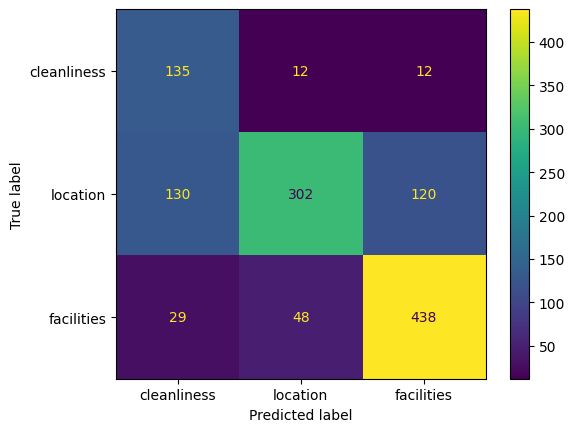

In [325]:
confusion_matrix = metrics.confusion_matrix(ground_truth_judges['Judges_classification'] , ground_truth_judges['NBC prediction'])
display_labels = ['cleanliness', 'location', 'facilities']
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)
cm_display.plot()
plt.show()

In [396]:
#Computing precision, accuracy and f1 score
precision = precision_score(ground_truth_judges['Judges_classification'], ground_truth_judges['NBC prediction'], average='weighted')
accuracy = accuracy_score(ground_truth_judges['Judges_classification'], ground_truth_judges['NBC prediction'])
f1 = f1_score(ground_truth_judges['Judges_classification'], ground_truth_judges['NBC prediction'], average='weighted')
recall = recall_score(ground_truth_judges['Judges_classification'], ground_truth_judges['NBC prediction'], average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Recalll: {recall:.2f}')

Precision: 0.76
Accuracy: 0.71
F1-score: 0.71
Recalll: 0.71


`SOLUTION V:`
According to the confusion matrix seen above, most of the reviews were classified correctly. This is represented by the fact that the number of true positives (878 across the main diagnal) are higher than the false negatives and false positives (351). 

Accuracy measures the fraction of predictions the NBC classifier got right. A fairly high accuracy percentage of 71% implies that our model was generally able to identify the reviews in the right category. Moreover, a precision percentage of 76% implies that there was a fairly high quality of the positive predictions made by the model. This high score also implies that the model was able to avoid false negatives succesfully in most cases. Thirdly, a recall percentage of 71% that our classifier was able capabable in indentifying true positives across all the positives (true and false). Finally, an F1 perecentage of 71% depicts the overall performance of the classifier and that the NBC had fairly good recall and precision 

# 8. Unsupervised Learning: Predicting Airbnb using LDA

`QUESTION VI:` Using Latent Dirichlet Allocation (LDA), predict the airbnb categories.

In [381]:
# ADD YOUR CODE HERE. Note: you are allowed to use the code from Session 03.
lexicon_content = likelihoods_content.iloc[:, 0].values.astype('U')
#Creating a countvectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             vocabulary={word: i for i, word in enumerate(lexicon_content)}, 
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                            )

# Applying the vectorizer
data_vectorized = vectorizer.fit_transform(df_sentences['sentences'][0:100])

# Setting the LDA parameters
SEED = 100
ITER = 1000
k = 5

log_likelihoods_list = []
for i in tqdm(range(1,k+1)):
    lda_model = LatentDirichletAllocation(n_components=i,               
                                      max_iter=ITER,
                                      learning_method='online',
                                      random_state=SEED,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )
    lda_output = lda_model.fit_transform(data_vectorized)
    log_likelihood_k = lda_model.score(data_vectorized)
    log_likelihoods_list.append(log_likelihood_k)

100%|█████████████████████████████████████████████| 5/5 [01:06<00:00, 13.34s/it]


In [398]:
best_likelihood = log_likelihoods_list.index(min(log_likelihoods_list))

best_lda_model = LatentDirichletAllocation(n_components=best_likelihood,               
                                      max_iter=ITER,
                                      learning_method='online',
                                      random_state=SEED,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )
best_lda_output = best_lda_model.fit_transform(data_vectorized)

print(f"The log-likelihood for best_likelihood = {best_likelihood} is {log_likelihoods_list[best_likelihood]:.3f}")

# The columns/topics names (formatting)
topic_names = ["Topic" + str(i + 1) for i in range(best_lda_model.n_components)]

# The rows/indices names (formatting)
doc_names = ["Review_" + str(i + 1) for i in range(data_vectorized.shape[0])]

# Posterior probabilities per document by topic
df_document_topic = pd.DataFrame(np.round(best_lda_output, 3), columns=topic_names, index=doc_names)
print(df_document_topic)

The log-likelihood for best_likelihood = 4 is -3338.230
            Topic1  Topic2  Topic3  Topic4
Review_1     0.063   0.063   0.063   0.812
Review_2     0.063   0.807   0.064   0.067
Review_3     0.023   0.023   0.023   0.931
Review_4     0.125   0.625   0.125   0.125
Review_5     0.050   0.050   0.050   0.850
...            ...     ...     ...     ...
Review_96    0.032   0.031   0.905   0.032
Review_97    0.026   0.924   0.025   0.025
Review_98    0.028   0.915   0.028   0.028
Review_99    0.025   0.025   0.025   0.924
Review_100   0.037   0.891   0.036   0.036

[100 rows x 4 columns]


In [399]:
df_document_topic.to_csv("LDA_df_document_topic.csv", index = False)

In [401]:
df_sentences['sentences'][0:100].to_csv("LDA_sentences.csv", index = False)

`SOLUTION VI:` Here are the following topics that we were able to classify:
**Topic 1:** Reviews in this topic that scored the highest seem to mention general comments of the Airbnb apartment and whether the reviewer like the apartment or not.
**Topic 2:** Reviews with the highest scores in this topic seem to be talking about the proximity to other attractions in town of the airbnb. For example, the center of the town, the mountains 
**Topic 3:** Reviews with the highest score in this topic tend to be about the host. Most comments mention how kind and helpful their host of the Airbnb was.
**Topic 4:** Reviews in this topic revolve arond the comfort of their stay. Most reviews mention how cozy and comfortable the airbnb property feels.

# 9. Unsupervised Learning: Predicting Airbnb Clusters using Word2Vec

`QUESTION VII:` Using Word2Vec, predict Airbnb reviews.
+ **Tip 1:** You can reduce the dimensionality of the output of Word2Vec with PDA/Factor Analysis. This will save you computing time.
+ **Tip 2:** Word2Vec wil give you word vectors. You can then compute the average of these word vectors for all words in a review. This will give you vector describing the content of a review, which you can use as your constructed variable(s).

In [369]:
# Splitting the full_data into training (70%) and testing (30%) data 
full_data = df_sentences['sentences'].tolist()

training_data = []
testing_data = []

for i in range(math.floor(0.7*len(full_data))):
    training_data.append(full_data[i])

for j in range(math.floor(0.7*len(full_data)), len(full_data)):
    testing_data.append(full_data[j])

In [370]:
# Tokenizing each sentence in the training data into a list of words
training_data = [simple_preprocess(line, deacc=True) for line in training_data]

# Number of topics for Word2Vec
topics_word2vec = 15

# Training the Word2Vec model
model = Word2Vec(training_data, vector_size=topics_word2vec, sg=0, epochs=20)

# The embeddings in gensim's Word2Vec model can be accessed via the 'wv' attribute
embeddings = model.wv

In [371]:
# Testing our Word2Vec model using our testing_data
# Initializing the embeddings matrix
all_embeddings = np.zeros((len(testing_data), topics_word2vec))

# Looping through each review
for review in range(len(testing_data)):
    # Tokenizing the review: identify the words, separately
    tokenized_review = simple_preprocess(testing_data[review])
    # Getting the word vectors per review
    embedding_review = [] # Initializing an empty list to store the word vectors
    # Looping through each word in the tokenized review
    for word in tokenized_review:
        # Checking if the word exists in the Word2Vec model vocabulary
        if word in model.wv.key_to_index:
            # If it does, get its vector and add it to the list
            word_vector = model.wv[word]
            embedding_review.append(word_vector)
    
    # Here, we handle the case where none of the words in the review are in the Word2Vec vocabulary
    if not embedding_review:
        continue
    
    # Compute mean across all words in the review 
    all_embeddings[review, :] = np.mean(embedding_review, axis=0)

In [372]:
# Word embeddings per document by topic (these are not probabilities!)
# The columns/topics names (formatting)
topic_names_w2v = ["Topic" + str(i + 1) for i in range(topics_word2vec)]

# The rows/indices names (formatting)
doc_names_w2v = ["Review_" + str(i + 1) for i in range(all_embeddings.shape[0])]

# Posterior probabilities per document by topic
df_document_w2v_topic = pd.DataFrame(np.round(all_embeddings, 3), columns=topic_names_w2v, index=doc_names_w2v)

In [373]:
#Applying PCA to reduce the total number of dimensions of the review vectors from 10 to 2
def compute_pca(X):
    # mean center the data
    X_demeaned = X - np.mean(X, axis = 0)
    
    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar = False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

    idx_sorted = np.argsort(eigen_vals)
    idx_sorted_decreasing = idx_sorted[::-1]
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]
    eigen_vecs_subset = eigen_vecs_sorted[:,0:2]
    
    # transform the data by multiplying the transpose of the eigenvectors with the transpose of the de-meaned data
    # Then take the transpose of that product.
    product = np.dot(np.transpose(eigen_vecs_subset),np.transpose(X_demeaned))
    X_reduced = np.transpose(product)

    return X_reduced

X_reduced = compute_pca(df_document_w2v_topic)

/Users/kunalr/Desktop/Big-Data-2023-Module-1-main/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


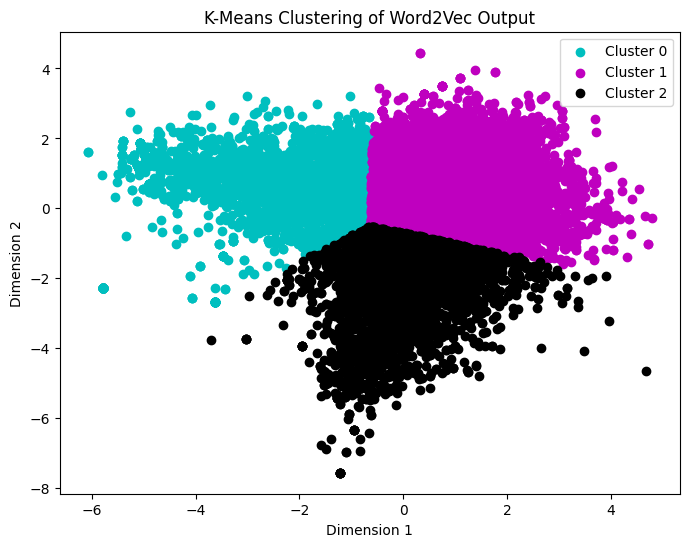

In [434]:
#Apply k-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_reduced)
cluster_labels = kmeans.labels_

plt.figure(figsize=(8, 6))
colors = ['c','m','k']

# Plot the data points with cluster assignments
for cluster in range(k):
    cluster_data = X_reduced[cluster_labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', c=colors[cluster])
    
# Add labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.title('K-Means Clustering of Word2Vec Output')

# Show the plot
plt.show()

#Creating binary variables dataframe
cluster_1 = np.zeros(len(cluster_labels), dtype=int)
cluster_2 = np.zeros(len(cluster_labels), dtype=int)
cluster_3 = np.zeros(len(cluster_labels), dtype=int)

# Assign values to binary lists based on cluster assignments
for i, label in enumerate(cluster_labels):
    if label == 0:
        cluster_1[i] = 1
    elif label == 1:
        cluster_2[i] = 1
    elif label == 2:
        cluster_3[i] = 1

`SOLUTION VII:`
These were the following steps taken to create sentence embeddings for our reviews. Firstly, the set of total reviews (full_data) was split into training and testing data at a 70v30% split respectively. After this, the Word2Vec model was trained using only training data. Thereafter, the testing data was used to create embeddings of our reviews. Given that the output of the Word2Vec model is a word embedding, the mean of all the word emebeddings included in one review was calculated. This gave us a vector representation for each sentence across 10 dimensions. However, to reduce the computation time and also be able to visualise our data, a PCA algorithm was deployed to reduce the dimensions from 10 to 2 for each review. After this, k-means clustering was applied to cluster all the reviews into 3 cluster, which correspond to out three categories cleanliness, location and facilities. Finally, in section 10, we will run a regression with these classified cluster columns.

# 10. Analysis: Use the constructed variables to answer your research question

`QUESTION VIII:` Now that you have constructed your NLP variables for sentiment and content using both supervised and unsupervised methods, use them to answer your original research question.

In [342]:
# ADD YOUR CODE HERE. The code for the analysis of your research question should be written here.
#Setting up our final datframe
rating = final_df['Rating'].tolist()
total_reviews = final_df['Total Reviews'].tolist()
host_mentioned = final_df['host_mentioned'].tolist()
df_sentences['rating'] = rating
df_sentences['total_reviews'] = total_reviews
df_sentences['host_mentioned'] = host_mentioned

In [402]:
#Regression model 1 - Supervised Learning
#creating the interaction variable in the dataframe
df_sentences['interaction_term'] = df_sentences['host_mentioned']*df_sentences['prob_sentiment']
df_sentences['intercept'] =1


X = df_sentences[['intercept', 'interaction_term' ,'p(positive|cleanliness)', 'p(positive|location)', 'p(positive|facilities)', 'total_reviews']]
y = df_sentences['rating']

model = sm.OLS(y, X).fit()
coefficients = model.params
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          5.03e-165
Time:                        22:32:22   Log-Likelihood:                 7015.6
No. Observations:               53895   AIC:                        -1.402e+04
Df Residuals:                   53889   BIC:                        -1.397e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

In [435]:
#Regression model 2 - Unsupervised learning Word2Vec model
# This is a continuation from the k-means clustering of the Word2Vec model in Section 9

test_data_length = len(full_data) - math.floor(0.7*len(full_data))
reviews_last_30_percent = df_sentences.tail(test_data_length)

#Creating a copy of the dataframe to be able to use in our regression model
df_copy = reviews_last_30_percent.copy()
df_copy['cluster_1'] = cluster_1.astype(int)
df_copy['cluster_2'] = cluster_2.astype(int)
df_copy['cluster_3'] = cluster_3.astype(int)

# apply multiple regression on this model with the independant variables 
X_unsupervised = df_copy[['intercept', 'interaction_term' ,'total_reviews', 'cluster_1', 'cluster_2', 'cluster_3']]
y_unsupervised = df_copy['rating']

model_unsupervised = sm.OLS(y_unsupervised, X_unsupervised).fit()
coefficients = model_unsupervised.params
print(model_unsupervised.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     61.96
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           4.76e-52
Time:                        23:31:14   Log-Likelihood:                 6827.0
No. Observations:               16169   AIC:                        -1.364e+04
Df Residuals:                   16164   BIC:                        -1.361e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            3.6391      0.001  

`SOLUTION VIII:`

`Regression model 1 analysis - Supervised learning`
From the output of the OLS model above, we see that all our independant variables have positive coeffecients which implies that there is a positive effect on the Airbnb rating. Firstly, the positive and statistically significant (at a 5% significance level) interaction term represents that when the host is mentioned review, a higher probability of a positive review has an even more positive impact on the rating when compared to when the host is not mentioned in the review. Therefore, for every unit increase in this interactio term, the rating of the Airbnb increases by 0.02
Secondly, the coeffecients for the variables that look at the probability across the three categories of reviews is positive and statistically significant (at a 10% significane level). More specifically, For every unit increase in the positive sentiment across cleanliness, location and facilities, the airbnb rating increases by 0.010, 0.019 and 0.011 respectively. We notice that a positive sentiment across location has the largest effect (almost double of that across cleanliness and facilities).
Finally, the we realise that the total number of reviews, despite being statistically significant has a very small positive effect on the airbnb reviews

`Regression model 2 analysis Unsupervised Word2Vec`
From the output of the second regression model we can see that the coeffecients for the cluster variables we created have a signficant effect. All three coeffecients for the three clusters seem to have a positive effect. However, cluster_1 seems to have the highest value, implying that if a review is in cluster 1, the airbnb ratings tend to be slightly higher. However, given that the coeffecients are more or less equal, it is a far reach to reach to that conclusion. We also see that the coeffecients of our interaction term is a lot higher in magnitude when compared to the case of supervised learning in regression model 1. These coeffecients still remain signficant.

`Answering our research question`
Therefore, to answer: To what extent are Airbnb ratings affected when sentiment about the host and sentiment towards cleanliness, location and facilities of the Airbnb are mentioned in an Airbnb review? 
Using all the analysis, we can confirm that positive sentiment towards the host seems to have a positive and significant effect towards the Airbnb ratings. Moreover, positive sentiment towards different aspects of the Airbnb itself also seems to have a positive effect towards the Airbnb, albeit these effects seem to be smaller when compared to sentiment towards the host,



# OPTIONAL: Run and interpret sentiment with the supervised learning VADER lexicon

`QUESTION IX (optional):` Using the VADER code you received in the lecture, compute the sentiment using the VADER package. Compare the performance of your NBC implementation (for sentiment) assuming that the VADER classification were the ground truth and then build the confusion matrix, compute the precision, and computre the recall. **Note** that we are now interested in understanding how much the two classifications differ and how, but we are not implying that VADER is error-free, far from it. We are interested in uncovering sources of systemic differences that can be attributed to the algorithms or lexicons. **Do interpret your findings**.

In [28]:
# ADD YOUR CODE HERE.

`SOLUTION IX (optional):`

# APPENDIX